In [163]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GRU + Meta data DAG model 


**Sequence Data Version:** `v5.1`


**Meta Data Version:**: `v2`



In [164]:
import numpy as np
import pandas as pd

# pd.set_option('')

import sys
sys.path.append('../')

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

## Load Datasets

In [165]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

from config import processed_data_dir


# Sequential Data
dataset_version = 'v5.1'

train_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'train.csv', index_col=0)
test_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'test.csv', index_col=0)
class_weight = 1-train_features_df.y.value_counts(normalize=True)

# Meta data
metadata_version = 'v2'
train_meta_df = pd.read_csv(processed_data_dir / 'meta_data' / metadata_version / "train_scaled.csv", index_col=0)
test_meta_df = pd.read_csv(processed_data_dir / 'meta_data' / metadata_version / "test_scaled.csv", index_col=0)

In [166]:
train_features_df.head()

,farm_id,time,ndvi_mean,ndvi_median,ndvi_std,ndvi_min,ndvi_max,cvi_mean,cvi_median,cvi_std,...,band_11_median,band_11_std,band_11_min,band_11_max,band_12_mean,band_12_median,band_12_std,band_12_min,band_12_max,y
0,1,2017-01-01,0.671766,0.692653,0.065668,0.454174,0.745895,inf,0.947159,NaN,...,0.0,1033.316114,0,2427,496.128571,0.0,526.755647,0,1422,Vineyard
1,1,2017-01-31,0.718396,0.729027,0.046242,0.586915,0.781602,inf,1.052384,NaN,...,0.0,1039.211662,0,2315,521.650000,0.0,549.157835,0,1382,Vineyard
2,1,2017-02-10,0.746055,0.755768,0.038175,0.633239,0.798810,1.977070,1.065654,4.086784,...,0.0,1155.934793,0,2482,508.700000,0.0,533.618506,0,1282,Vineyard
3,1,2017-03-12,0.668629,0.684211,0.065733,0.514993,0.765019,2.180335,0.865489,3.647409,...,0.0,938.965428,0,2011,466.950000,0.0,490.728297,0,1187,Vineyard
4,1,2017-03-22,0.659258,0.673052,0.055294,0.511155,0.747845,2.783775,1.226074,5.027783,...,0.0,911.059519,0,1981,433.728571,0.0,455.879587,0,1105,Vineyard


## Process Data

### Sequential Data

In [167]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def impute_nan_inf(df):
    """
    Impute bad values (nan and inf) using
    the median of that feature on that time stamp
    for all farms
    
    TODO: This can be improved
    """
    
    # replace all nans variants with np.nan
    df = df.replace([np.nan, None, np.inf, -np.inf], 0)

#     # replace all nans with the median value of all farms on that timestamp
#     for ts, ts_df in df.groupby('time'):
#         df.loc[ts_df.index] = ts_df.fillna(ts_df.median())
        
    return df

In [168]:
train_features_df = impute_nan_inf(train_features_df)
test_features_df = impute_nan_inf(test_features_df)

In [169]:
train_features_df.head()

,farm_id,time,ndvi_mean,ndvi_median,ndvi_std,ndvi_min,ndvi_max,cvi_mean,cvi_median,cvi_std,...,band_11_median,band_11_std,band_11_min,band_11_max,band_12_mean,band_12_median,band_12_std,band_12_min,band_12_max,y
0,1,2017-01-01,0.671766,0.692653,0.065668,0.454174,0.745895,0.000000,0.947159,0.000000,...,0.0,1033.316114,0,2427,496.128571,0.0,526.755647,0,1422,Vineyard
1,1,2017-01-31,0.718396,0.729027,0.046242,0.586915,0.781602,0.000000,1.052384,0.000000,...,0.0,1039.211662,0,2315,521.650000,0.0,549.157835,0,1382,Vineyard
2,1,2017-02-10,0.746055,0.755768,0.038175,0.633239,0.798810,1.977070,1.065654,4.086784,...,0.0,1155.934793,0,2482,508.700000,0.0,533.618506,0,1282,Vineyard
3,1,2017-03-12,0.668629,0.684211,0.065733,0.514993,0.765019,2.180335,0.865489,3.647409,...,0.0,938.965428,0,2011,466.950000,0.0,490.728297,0,1187,Vineyard
4,1,2017-03-22,0.659258,0.673052,0.055294,0.511155,0.747845,2.783775,1.226074,5.027783,...,0.0,911.059519,0,1981,433.728571,0.0,455.879587,0,1105,Vineyard


In [170]:
# Make copies to compare before / after normalization
train_copy = train_features_df.copy()
test_copy = test_features_df.copy()

times = train_features_df['time'].unique()

feature_cols = [col for col in test_features_df.columns if col not in ['farm_id','time']]

for i, ts in enumerate(times):
    
    train_ts_df = train_copy[train_copy.time == ts]
    test_ts_df = test_copy[test_copy.time == ts]
    
#     if i == 0:
#         scaler = StandardScaler()
#         scaler.fit(train_ts_df[feature_cols])

    scaler = StandardScaler()
    scaler.fit(train_ts_df[feature_cols])
    
    train_features_df.loc[train_ts_df.index, feature_cols] = scaler.transform(train_ts_df[feature_cols])
    test_features_df.loc[test_ts_df.index, feature_cols] = scaler.transform(test_ts_df[feature_cols])
    

In [171]:
def transform_dataset(features_df):
    """
    Create a data array in the shape (n_ids, n_time, n_features)
    
    If it is the training set, also return dictionary mapping index
    in dataset to correct label.
    
    """
    
    n_ids = features_df.farm_id.nunique()

    feature_cols = [col for col in features_df.columns if col not in ['farm_id','y','time']]
    
    n_features = len(feature_cols)

    data = np.ndarray((n_ids, 11, n_features))
    
    classes = {}
    for i, (farm_id, farm_df) in enumerate(features_df.groupby(['farm_id'])):

        data[i,:,:] = farm_df[feature_cols].values
        
        if 'y' in features_df.columns:
            c = farm_df['y'].unique()
            classes[i] = c[0]
            
    return data, classes

    
    
train_data, train_labels_dict = transform_dataset(train_features_df)
test_data, _ = transform_dataset(test_features_df)

print('Sequential Datasets:')
print('Train data:\t\t',train_data.shape)
print('Test data:\t\t',test_data.shape)

Sequential Datasets:
Train data:		 (2494, 11, 110)
Test data:		 (1074, 11, 110)


### Meta Data

In [172]:
train_meta_df.head()

,Area,Subregion_3.0,Subregion_1.0,Subregion_4.0,Subregion_2.0,Subregion_5.0,Subregion_6.0,Subregion_0.0,Subregion_7.0,lat,...,distance_4,Cotton,Dates,Grass,Lucern,Maize,Pecan,Vacant,Vineyard,"Vineyard & Pecan (""Intercrop"")"
Field_Id,,,,,,,,,,,,,,,,,,,,,
1,-0.589766,1,0,0,0,0,0,0,0,1.739183,...,1.299743,-0.364116,-0.110013,-0.387037,-0.866913,-0.555023,2.329529,-0.635723,2,1.738146
2,-0.157671,1,0,0,0,0,0,0,0,1.761063,...,-0.304332,-0.364116,-0.110013,-0.387037,-0.043890,-0.555023,-0.403873,-0.635723,3,1.738146
3,-0.527917,1,0,0,0,0,0,0,0,1.753355,...,-0.061299,0.856456,-0.110013,-0.387037,-0.866913,-0.555023,0.962828,-0.635723,2,1.738146
4,-0.439169,1,0,0,0,0,0,0,0,1.764898,...,0.222124,0.856456,-0.110013,-0.387037,-0.043890,-0.555023,0.962828,-0.635723,1,1.738146
7,1.145875,1,0,0,0,0,0,0,0,1.765042,...,0.031368,-0.364116,-0.110013,-0.387037,-0.043890,-0.555023,0.962828,-0.635723,3,-0.316326


In [173]:
train_meta_data = train_meta_df.values
test_meta_data = test_meta_df.values

print('Meta Data Shape: ')
print('Train:\t',train_meta_data.shape)
print('Test:\t',test_meta_data.shape)

Meta Data Shape: 
Train:	 (2494, 30)
Test:	 (1074, 30)


## Start Modelling Process

### Create validation set

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

seed = 420

# Copy for later
data = train_data.copy()

train_labels = list(train_labels_dict.values())
train_indexes = list(train_labels_dict.keys())

train_idx, val_idx, train_labels, val_labels = train_test_split(train_indexes, train_labels, 
                                                                stratify=train_labels, 
                                                                test_size=0.2, random_state=seed)

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(train_labels).reshape(-1,1))
val_labels_enc = le.transform(np.array(val_labels).reshape(-1,1))

train_data = data[train_idx,:, :]
val_data = data[val_idx,:, :]

# Split Meta data into train and val
train_data_meta = train_meta_data[train_idx,:]
val_data_meta = train_meta_data[val_idx,:]

print('Split Dataset Shapes:')
print('train data:\t Seq: {}\t Meta: {}'.format(train_data.shape, train_data_meta.shape))
print('train data:\t Seq: {}\t Meta: {}'.format(val_data.shape, val_data_meta.shape))

Split Dataset Shapes:
train data:	 Seq: (1995, 11, 110)	 Meta: (1995, 30)
train data:	 Seq: (499, 11, 110)	 Meta: (499, 30)


### Create model

In [184]:
import tensorflow as tf
import keras
from keras import models, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from src.visualization.tf_viz import PlotLosses

from keras.layers import Input, Dense
from keras.models import Model

def get_dag_model(n_ts_features, n_meta_features):
    
    # Get the model
    GRU_cells = 8
    recurrent_activation = 'hard_sigmoid'
    recurrent_dropout = 0.6093571771811351


    # Temporal Model
    input_timeseries = Input(shape=(11,n_ts_features,))

    x = layers.Dense(64, activation='relu')(input_timeseries)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout)(x)
    x = layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout)(x)
    x = layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout)(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    
    # Meta Model
    input_meta_data = Input(shape=(n_meta_features,))

    y = layers.Dense(64, activation='relu',)(input_meta_data)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(16, activation='relu')(y)
    y = layers.Dropout(0.1)(y)
    y = layers.BatchNormalization()(y)

    bottleneck = layers.concatenate([x,y])
    bottleneck = layers.Dense(50, activation='relu')(bottleneck)
    bottleneck = layers.Dropout(0.3)(bottleneck)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Dense(9, activation='softmax')(bottleneck)

    model = Model(inputs=[input_timeseries,input_meta_data], outputs=bottleneck)
    
    return model

### Set modelling parameters

In [185]:
from src.models.clr_callback import CyclicLR
from keras.callbacks import ModelCheckpoint

from config import models_dir


lr = 0.00015

# Choose optimizer
optimizer = keras.optimizers.RMSprop(lr)
# optimizer = keras.optimizers.Adam(lr)


plot_losses = PlotLosses()
es = EarlyStopping(monitor='val_loss', verbose=1, patience=100)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=50, verbose=1, factor=0.5, min_delta=0.001,)

checkpoint = ModelCheckpoint(str(models_dir / f'gru_dag_val_{dataset_version}.{metadata_version}.hdf5'), 
                             save_best_only=True, 
                             mode='min', 
                             monitor='val_loss')


# Combine Callbacks
callbacks = [
    plot_losses, 
    es, 
    reduce_lr,
    checkpoint
]

# Create model & compile
model = get_dag_model(train_data.shape[-1], train_data_meta.shape[-1])

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 11, 110)      0                                            
__________________________________________________________________________________________________
dense_152 (Dense)               (None, 11, 64)       7104        input_45[0][0]                   
__________________________________________________________________________________________________
batch_normalization_152 (BatchN (None, 11, 64)       256         dense_152[0][0]                  
__________________________________________________________________________________________________
dropout_152 (Dropout)           (None, 11, 64)       0           batch_normalization_152[0][0]    
__________________________________________________________________________________________________
dense_153 

## TRAIN!!

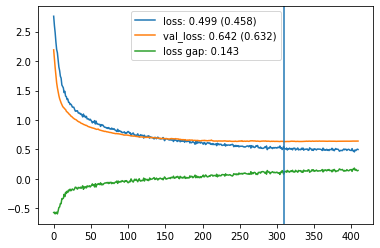


Epoch 00410: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
Epoch 00410: early stopping


In [186]:
batch_size = 64
epoch_size = 1000

model.fit([train_data, train_data_meta], 
          train_labels_enc,
          batch_size=batch_size,
          validation_data=([val_data, val_data_meta], val_labels_enc), 
          class_weight=class_weight,
          verbose=0,
          epochs=epoch_size, 
          callbacks=callbacks)

### Inspect best model performance

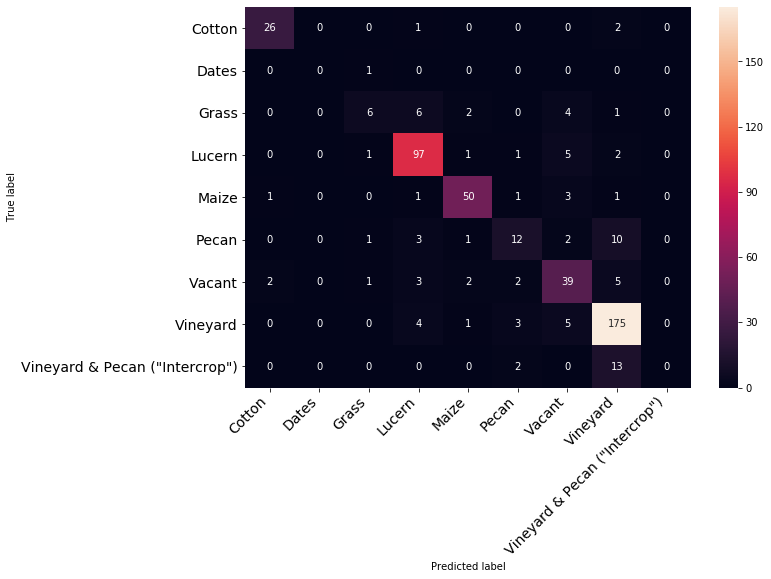

In [210]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

# Load best model
best_model = load_model(str(models_dir / f'gru_dag_val_{dataset_version}.{metadata_version}.hdf5'))

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

val_probs = best_model.predict([val_data, val_data_meta])

val_preds = np.argmax(val_probs, axis=1)

cm = confusion_matrix(val_labels_enc, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

In [198]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(val_labels_enc, val_preds, output_dict=True))

,0,1,2,3,4,5,6,7,8,accuracy,macro avg,weighted avg
f1-score,0.896552,0.0,0.413793,0.873874,0.877193,0.480000,0.696429,0.881612,0.0,0.811623,0.568828,0.790855
precision,0.896552,0.0,0.600000,0.843478,0.877193,0.571429,0.672414,0.837321,0.0,0.811623,0.588710,0.777455
recall,0.896552,0.0,0.315789,0.906542,0.877193,0.413793,0.722222,0.930851,0.0,0.811623,0.562549,0.811623
support,29.000000,1.0,19.000000,107.000000,57.000000,29.000000,54.000000,188.000000,15.0,0.811623,499.000000,499.000000


### Now on all data

In [199]:
all_data = np.vstack([train_data, val_data])
all_labels = np.array(list(train_labels_enc) + list(val_labels_enc))

all_data_meta = np.vstack([train_data_meta, val_data_meta])

class_weight = (1 - pd.Series(all_labels).value_counts(normalize=True)).to_dict()

In [217]:
from src.models.clr_callback import CyclicLR
from keras.callbacks import ModelCheckpoint

from config import models_dir

from keras.layers import Input, Dense
from keras.models import Model

lr = 0.00015

# Choose optimizer
optimizer = keras.optimizers.RMSprop(lr)
f_checkpoint = str(models_dir / f'gru_dag_{dataset_version}.{metadata_version}.hdf5')
checkpoint = ModelCheckpoint(f_checkpoint, 
                             save_best_only=True, 
                             mode='min', 
                             monitor='loss')
callbacks = [
    plot_losses, 
    checkpoint
]

model = get_dag_model(all_data.shape[-1], all_data_meta.shape[-1])

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 11, 110)      0                                            
__________________________________________________________________________________________________
dense_170 (Dense)               (None, 11, 64)       7104        input_51[0][0]                   
__________________________________________________________________________________________________
batch_normalization_170 (BatchN (None, 11, 64)       256         dense_170[0][0]                  
__________________________________________________________________________________________________
dropout_170 (Dropout)           (None, 11, 64)       0           batch_normalization_170[0][0]    
__________________________________________________________________________________________________
dense_171 

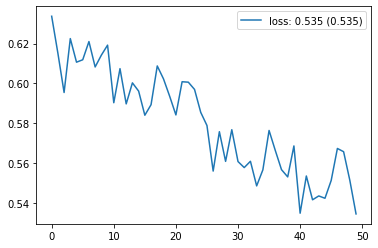

In [219]:
epochs=50

model.fit([all_data,all_data_meta], 
          all_labels,
          batch_size=batch_size,
          class_weight=class_weight,
          verbose=0,
          epochs=epochs, 
          callbacks=callbacks)

### Load Best Model

In [220]:
from keras.models import load_model

model = load_model(f_checkpoint)

## Make a submission

In [225]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict([test_data, test_meta_data])
test_ids = sorted(list(test_features_df.farm_id.unique()))
sub_df = make_sub(predictions, test_ids)
sub_df.head()

,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,0.006342,0.007604,0.002189,0.001797,0.001493,0.089571,0.000378,0.616365,0.274260
6,0.002650,0.006983,0.001984,0.001539,0.002325,0.171419,0.001052,0.516132,0.295916
10,0.002191,0.003530,0.001158,0.000773,0.000193,0.021720,0.000277,0.769220,0.200938
18,0.000254,0.001089,0.000306,0.000058,0.000036,0.001222,0.000093,0.949352,0.047589
23,0.000168,0.001025,0.000342,0.000032,0.000072,0.000972,0.000064,0.951347,0.045977


### Save submission file

In [227]:
from config import subs_dir

fname = 'gru_dag_data_v5.2_x'
sub_df.to_csv(subs_dir / f'{fname}.csv')

### Save model architecture

In [228]:
with open(subs_dir / 'architectures' / f'{fname}.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))